## Experimental Datasets

Finally, let's investigate a small MoS$_2$ experimental dataset, which can be found [here](https://github.com/yijiang1/fold_slice/blob/main/ptycho/python/data_mos2_sample.mat).  
At a minimum, we require the experiment energy, step size and angular sampling, but many experimental configurations will also have the following properties:
- `rotation_angle` [rad]: relative rotation between CBED patterns and scan positions (due to electron's helical path off the optic axis)
- `background_counts_cutoff`: counts below which intensities are set to zero
- `counts_scaling_function`: conversion factor to switch between measured intensities to actual electron counts (not strictly necessary)

In [1]:
import numpy as np
from scipy.io import loadmat
from abtem.utils import energy2wavelength

rotation_angle = 30 / 180 * np.pi
adu_background_cutoff = 20
adu = 149
dataset = loadmat("../data/data_mos2_sample.mat")
raw_data = np.transpose(dataset["dp"], (3, 2, 0, 1))  # transposes cbed
energy = np.squeeze(dataset["voltage"] * 1e3).item()
semiangle = np.squeeze(dataset["alpha_max"]).item()

step_size_real_space = (
    np.squeeze(dataset["scanStepSize_x"]).item(),
    np.squeeze(dataset["scanStepSize_y"]).item(),
)
reciprocal_space_sampling_invang = np.squeeze(dataset["dk"]).item()
reciprocal_space_sampling_mrad = (
    energy2wavelength(energy) * 1e3 * reciprocal_space_sampling_invang,
) * 2

We can use these properties to set up a `Measurement` object.  
Alternatively, we could pass raw_data directly to the operator, but this allows us to perform some sanity checks by plotting an ADF and PACBED image.

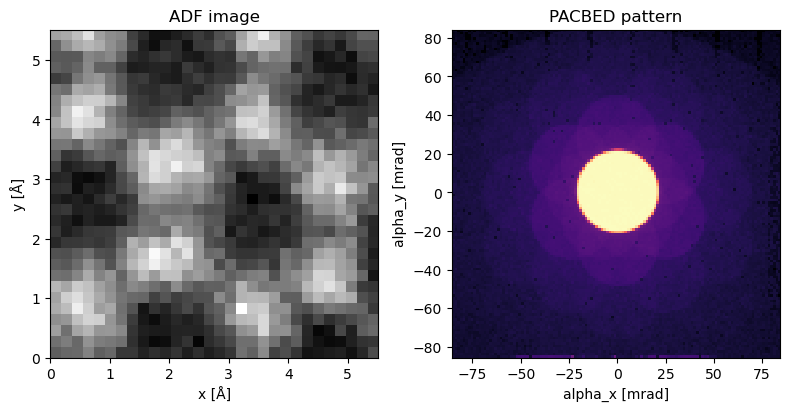

In [2]:
from abtem.measure import Calibration, Measurement
from abtem.detect import AnnularDetector
import matplotlib.pyplot as plt

calibrations = tuple(
    Calibration(0.0, d, "Å", name, endpoint=False)
    for name, d in zip(("x", "y"), step_size_real_space)
)
calibrations += tuple(
    Calibration(-dk * n / 2, dk, "mrad", name, endpoint=False)
    for name, dk, n in zip(
        ("alpha_x", "alpha_y"), reciprocal_space_sampling_mrad, raw_data.shape[2:]
    )
)

raw_data[raw_data < adu_background_cutoff] = 0.0
experimental_measurement = Measurement(raw_data, calibrations)
adf = AnnularDetector(
    inner=semiangle, outer=reciprocal_space_sampling_mrad[0] * raw_data.shape[2] / 2
).integrate(experimental_measurement)
pacbed = experimental_measurement.mean(axis=(0, 1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

adf.show(ax=ax1, title="ADF image")
pacbed.show(power=0.25, ax=ax2, cmap="magma", title="PACBED pattern")

fig.tight_layout()

We use a two-probe mixed-state reconstruction algorithm.  
We specify an ROI slightly larger than our CBED patterns (to demonstrate padding), and in contrast to the simulations above do not specify `object_px_padding` directly. Instead, the `preprocess()` method will pad by half the ROI on each side of the rotated positions.

In [3]:
from abtem.reconstruct import MixedStatePtychographicOperator

experimental_ptycho_operator = MixedStatePtychographicOperator(
    experimental_measurement,
    region_of_interest_shape=(128, 128),
    num_probes=2,
    semiangle_cutoff=semiangle,
    energy=energy,
    device="gpu",
    parameters={
        "background_counts_cutoff": adu_background_cutoff,
        "counts_scaling_factor": adu,
        "rotation_angle": rotation_angle,
    },
).preprocess()

(
    exp_objects,
    exp_probes,
    exp_positions,
    exp_sse,
) = experimental_ptycho_operator.reconstruct(
    max_iterations=50,
    random_seed=1,
    return_iterations=True,
    parameters={
        "pure_phase_object_update_steps": experimental_ptycho_operator._num_diffraction_patterns
        * 10
    },
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

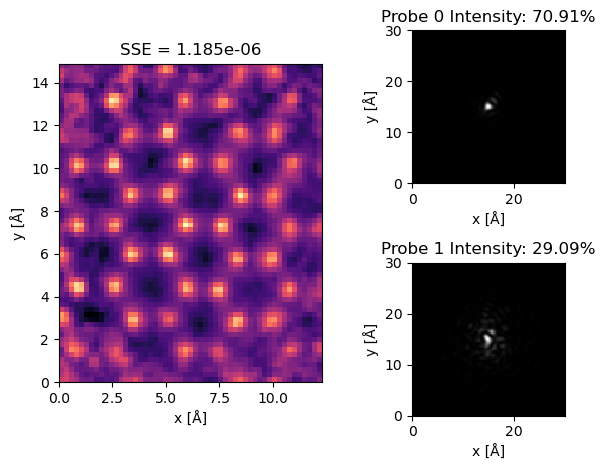

In [4]:
probe_intensity_ratios = np.sum(
    [probe.intensity().array for probe in exp_probes[-1]], axis=(-2, -1)
)
probe_intensity_ratios /= np.sum(probe_intensity_ratios) / 100

fig, axd = plt.subplot_mosaic(
    [["left", "top-right"], ["left", "bottom-right"]], constrained_layout=True
)
exp_objects[-1].crop(extent=(25, 27.5), origin=(12.5, 12.5)).angle().show(
    ax=axd["left"], title=f"SSE = {float(exp_sse[-1]):.3e}", cmap="magma"
)
exp_probes[-1][0].intensity().show(
    ax=axd["top-right"], title=f"Probe 0 Intensity: {probe_intensity_ratios[0]:.2f}%"
)
exp_probes[-1][1].intensity().show(
    ax=axd["bottom-right"], title=f"Probe 1 Intensity: {probe_intensity_ratios[1]:.2f}%"
)
fig.tight_layout()

Indeed, this is significantly better than our ADF!  
Note also we are able to reconstruct a larger field-of-view due to our moving probe having a finite extent with relevant scattering information